##### 1. Packages
**For, collab, uncomment and install the packages specified below**

In [13]:
!pip3 install torch torchvision torchaudio


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
!pip install stable-baselines3[extra] protobuf==3.20.*

   ---------------------------------------- 0.0/162.1 kB ? eta -:--:--
   -- ------------------------------------- 10.2/162.1 kB ? eta -:--:--
   --------------- ------------------------ 61.4/162.1 kB 1.1 MB/s eta 0:00:01
   ---------------------- ---------------- 92.2/162.1 kB 871.5 kB/s eta 0:00:01
   ---------------------------- --------- 122.9/162.1 kB 804.6 kB/s eta 0:00:01
   ---------------------------- --------- 122.9/162.1 kB 804.6 kB/s eta 0:00:01
   --------------------------------- ---- 143.4/162.1 kB 607.9 kB/s eta 0:00:01
   -------------------------------------- 162.1/162.1 kB 573.2 kB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# !pip install mss pydirectinput pytesseract


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


##### 1. Import the dependencies
**For, collab, uncomment and install the packages specified below**

In [18]:
from mss import mss # used for screen capture 
import pydirectinput # used for keyboard input
import cv2 #used for image processing
import numpy as np 
import pytesseract #used for text recognition
from matplotlib import pyplot as plt
import time
from gym import Env # used for creating custom environment
from gym.spaces import Box, Discrete # used for defining action and observation space

#### 2. Build the Environment

2.1 Create Environment

In [19]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [20]:
env = WebGame()

In [21]:
obs=env.get_observation()

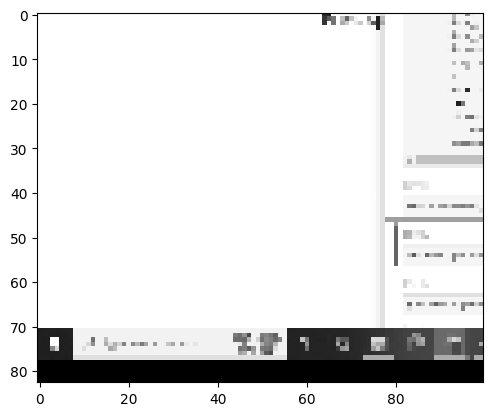

In [22]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [ ]:
done, done_cap = env.get_done()

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

: 

In [ ]:
plt.imshow(done_cap)

In [ ]:
pytesseract.image_to_string(done_cap)[:4]

In [ ]:
done

In [ ]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

#### 3. Train the Model

3.1 Create Callback

# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [ ]:
env_checker.check_env(env)

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

3.2 Build DQN and Train

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [ ]:
env = WebGame()